In [0]:
!git clone https://www.github.com/ildoonet/tf-pose-estimation
%cd tf-pose-estimation
!pip install -r requirements.txt
!sudo apt install swig
%cd tf_pose/pafprocess/
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
%cd ..
%cd ..

In [0]:
%cd models/graph/cmu
!bash download.sh
%cd /content/tf-pose-estimation

In [3]:
import tf_pose
from tf_pose import common
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from PIL import Image, ImageDraw

def get_w_h(x):
    return model_wh(x)

def get_p_estimator(x,w,h):
    return TfPoseEstimator(get_graph_path(x), target_size=(w, h))

def get_np_img(x):
    return common.read_imgfile(x, None, None)

def get_draw_humans(x,y):
	return TfPoseEstimator.draw_humans(x, y, imgcopy=False)

def round_down(num, divisor):
    return num - (num%divisor)

W0708 09:14:42.929591 140584234149760 deprecation_wrapper.py:119] From /content/tf-pose-estimation/tf_pose/mobilenet/mobilenet.py:369: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



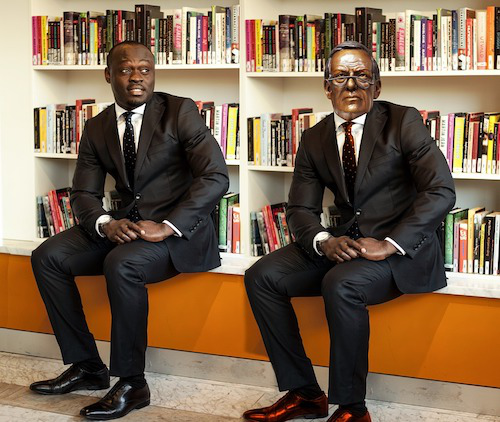

In [29]:
image_path = "./images/p2.jpg"

Image.open(image_path)

In [0]:
x = image_path

image_size = Image.open(x).size
rounded_w = round_down(image_size[0],16)
rounded_h = round_down(image_size[1],16)

y = "mobilenet_thin"
#y = "cmu"


z = "432x368"
#z = "656x368"
#z = "1312x736"


w,h = get_w_h(z)
e = get_p_estimator(y,w,h)
n_image = get_np_img(x)
humans = e.inference(n_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
image = get_draw_humans(n_image,humans)

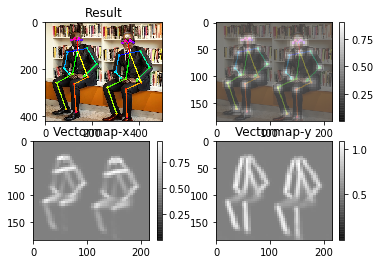

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
a = fig.add_subplot(2, 2, 1)
a.set_title('Result')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

# show network output
a = fig.add_subplot(2, 2, 2)
plt.imshow(bgimg, alpha=0.5)
tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
plt.colorbar()

tmp2 = e.pafMat.transpose((2, 0, 1))
tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

a = fig.add_subplot(2, 2, 3)
a.set_title('Vectormap-x')
# plt.imshow(CocoPose.get_bgimg(inp, target_size=(vectmap.shape[1], vectmap.shape[0])), alpha=0.5)
plt.imshow(tmp2_odd, cmap=plt.cm.gray, alpha=0.5)
plt.colorbar()

a = fig.add_subplot(2, 2, 4)
a.set_title('Vectormap-y')
# plt.imshow(CocoPose.get_bgimg(inp, target_size=(vectmap.shape[1], vectmap.shape[0])), alpha=0.5)
plt.imshow(tmp2_even, cmap=plt.cm.gray, alpha=0.5)
plt.colorbar()
plt.show()


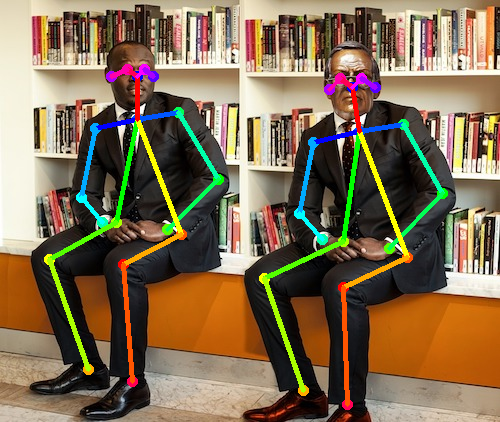

In [15]:
data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
Image.fromarray(data, 'RGB')

# 部位ごとのestimation

In [0]:
images = [image_path]


#y = "mobilenet_thin"
y = "cmu"

detect_size = True
z = "432x368"
#z = "656x368"
#z = "1312x736"

estimated_data = []
for i in images:
    if detect_size == True:
        image_size = Image.open(i).size
        rounded_w = round_down(image_size[0],16)
        rounded_h = round_down(image_size[1],16)
        z = "{}x{}".format(str(rounded_w),str(rounded_h))
        w,h = rounded_w, rounded_h
        e = get_p_estimator(y,w,h)
        n_image = get_np_img(i)
        humans = e.inference(n_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
        estimated_data.append(humans)
    else:
        image_size = Image.open(i).size
        w,h = get_w_h(z)
        e = get_p_estimator(y,w,h)
        n_image = get_np_img(i)
        humans = e.inference(n_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
        estimated_data.append(humans)
        image = get_draw_humans(n_image,humans)
        
        


In [0]:
arranged_estimated_data = []
for i in estimated_data:
    if len(i) > 1:
        print(i)
        for i2 in i:
            arranged_estimated_data.append([i2])
    else:
        arranged_estimated_data.append(i)

In [0]:
import re
import numpy as np

pattern = '\(.+?\)'
box_data = []

#パーツ指定。デフォルトはNone
parts_number = [4,7,9,10,12,13]
# 0   Nose　　　　　　　　　　　 鼻
# 1   Neck 　　　　　　　　　　　首
# 2   RShoulder　　　 右肩
# 3   RElbow 　　　　　　　　右肘
# 4   RWrist 　　　　　　　　　右手首
# 5   LShoulder 　　　左肩
# 6   LElbow 　　　　　　　　左肘
# 7   LWrist 　　　　　　　　　左手首
# 8   RHip 　　　　　　　　　　　　右腰
# 9   RKnee 　　　　　　　　　右膝
# 10 RAnkle 　　　　　　　　右足首
# 11 LHip 　　　　　　　　　　　　左腰
# 12 LKnee 　　　　　　　　　左膝
# 13 LAnkle 　　　　　　　　左足首
# 14 REye 　　　　　　　　　　　右目
# 15 LEye 　　　　　　　　　　　左目
# 16 REar 　　　　　　　　　　　　右耳
# 17 LEar 　　　　　　　　　　　　左耳
# 18 Background 背景

original_image_h = image_size[0]
original_image_w = image_size[1]

for i in arranged_estimated_data:
    if parts_number == None :
        #パーツを全て取り出すループ
        for n in range(19):
            try:
                #パーツ部分を抽出
                a = i[0].body_parts[n]
                #()に囲まれている部分を抽出
                a2 = re.search(pattern, str(a))
                #()を削除し,数値を２つに分割
                t,g = a2.group().strip("("")").split(",")
                t = int(float(t)*original_image_h)
                g = int(float(g)*original_image_w)
                _list = [n,np.array([t-4,g-4,t+4,g+4])]
                box_data.append(_list)
            except:
                pass
    #パーツ指定がある場合
    else:
        for n in parts_number:
            try:
                a = i[0].body_parts[n]
                #()に囲まれている部分を抽出
                a2 = re.search(pattern, str(a))
                #()を削除し,数値を２つに分割
                t,g = a2.group().strip("("")").split(",")
                t = int(float(t)*original_image_h)
                g = int(float(g)*original_image_w)
                _list = [n,np.array([t-4,g-4,t+4,g+4])]
                box_data.append(_list)
            except:
                pass


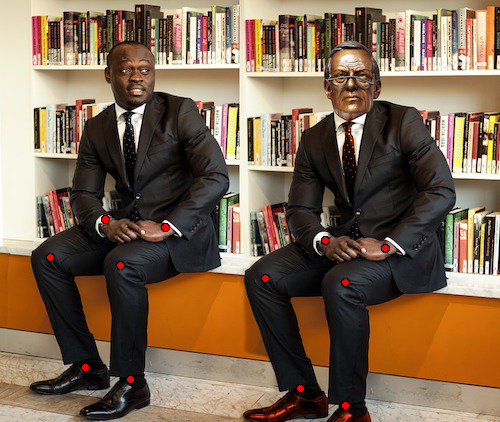

In [36]:
im = Image.open(image_path)
draw = ImageDraw.Draw(im)
for i in box_data:
    dd = tuple(i[1])
    draw.ellipse(dd, fill=(255, 0, 0), outline=(0, 0, 0))

im
# im.save('imagedraw.jpg', quality=95)
# Image.open("imagedraw.jpg")